Author: Ben Garrett<br>
Created Date: 12/28/2020

*The following article is writen as a Jupyter Notebook. All code can be run and tweaked by clicking the 'Open in Colab' button.*

# Introduction

One of the most promising uses of machine learning for image classification is the automation of inspection tasks using photos collected by drones. 

Maintaining infrastructure is essential to public safety and for cost-savings by catching problems early before they become expensive to repair. In the United States, there is a huge backlog of inspections of bridges, dams, levees and other large concrete structures. Reducing the cost and increasing the efficiency of inspection of such structures could save millions of dollars and potentially human lives. Drones are becoming more affordable and their controlability and photo performance is making them an attractive tool for inspection processes. Using drones to collect photos of infrastructure may save time and money in itself, but this can be compounded if the image processing could be automated with machine learning.

In this project, images of concrete labled as 'cracked' or 'not_cracked' will be classified using a convolutional neural network. It is easy to imagine a local government deploying a model like this to reduce inspection costs, increase the amount of infrastructure that can be inspected in a given year, and to increase public public safety. 

## The Data

The dataset was first documented in the paper:<br>

L. Zhang, F. Yang, Y. Daniel Zhang and Y. J. Zhu, "Road crack detection using
deep convolutional neural network," 2016 IEEE International Conference on Image Processing (ICIP), Phoenix, AZ, 2016, pp. 3708-3712,  doi: 10.1109/ICIP.2016.7533052.

And can be downloaded at: 

https://data.mendeley.com/datasets/5y9wdsg2zt/2\

The data comes as a .rar file, which I unzipped with 7Zip. The files are arranged in a directory with a train and test folder, and within each a positive and negative folder with the corresponding images. I renamed the folders to 'crack' and 'no_crack' to be more clear. The below code will download a copy of this dataset I have hosted on Github. 

## Imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import glob
import pandas as pd
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from PIL import Image
from sklearn.calibration import calibration_curve
import os, requests, zipfile
!pip install GitPython
from git import Repo

print('Ready to go!')

Ready to go!


## Import Images

Below is the file structure of the dataset: 
```
/Concrete Crack Images for Classification
            /train
                /crack
                /no_crack
            /test
                /crack
                /no_crack
            /val
                /crack
                /no_crack
```
Using Keras' image dataset from directory tool, we can pull in the photos, resize them if necessary, and do any other type of preprocessing we want. The tool lets you specify the validation split for the train data, but you could also have a seperate 'val' directory as well. The last two lines let you specify the amount of persistant memory for the two datasets to speed training.

#### **The following code downloads around 500 MB of photos into the current working directory, it may take a bit. The last code cell will delete all downloaded data.
                


In [2]:
batch_size = 64
photo_height = 227
photo_width = 227

filepath = 'temp_concrete_crack'

try:
    Repo.clone_from('https://github.com/bimewok/Concrete-Crack-Image-Classifier', filepath)
except:
    pass

train_path = r'{temp_concrete_crack}/data/concrete_images/train'.format(temp_concrete_crack=filepath)
val_path = r'{temp_concrete_crack}/data/concrete_images/val'.format(temp_concrete_crack=filepath)
test_path = r'{temp_concrete_crack}/data/concrete_images/test'.format(temp_concrete_crack=filepath)

train = tf.keras.preprocessing.image_dataset_from_directory(
  train_path,
  validation_split=None,
  subset=None,
  seed=42,
  image_size=(photo_height, photo_width),
  batch_size=batch_size)

val = tf.keras.preprocessing.image_dataset_from_directory(
  val_path,
  validation_split=None,
  subset=None,
  seed=42,
  image_size=(photo_height, photo_width),
  batch_size=batch_size)

classes = train.class_names
print('classes: ' +str(classes))

AUTOTUNE = tf.data.experimental.AUTOTUNE

train = train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)

Found 28000 files belonging to 2 classes.
Found 8000 files belonging to 2 classes.
classes: ['crack', 'no_crack']


## Visualize some of the photos

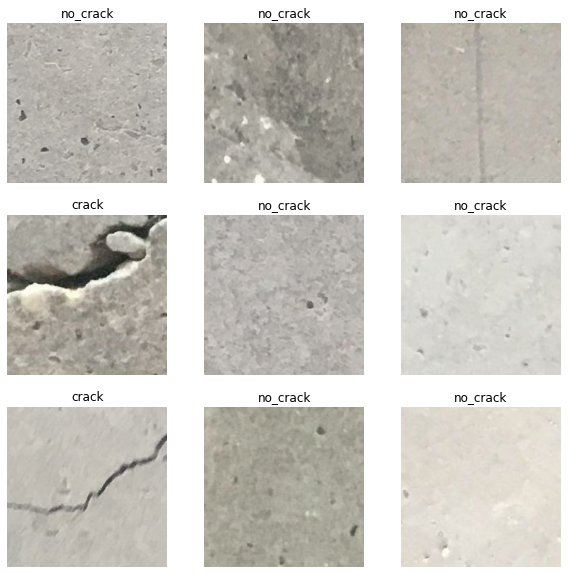

In [3]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")
    
plt.show()

In [4]:
tf.keras.backend.clear_session()

num_classes = 2

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
    
    
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

print('compiled!')

compiled!


Epoch 1/30
438/438 [==============================] - 30s 62ms/step - loss: 0.3527 - accuracy: 0.8435 - val_loss: 0.0988 - val_accuracy: 0.9824
INFO:tensorflow:Assets written to: temp_concrete_crack\assets
Epoch 2/30
438/438 [==============================] - 9s 21ms/step - loss: 0.0625 - accuracy: 0.9832 - val_loss: 0.0478 - val_accuracy: 0.9896
INFO:tensorflow:Assets written to: temp_concrete_crack\assets
Epoch 3/30
438/438 [==============================] - 9s 21ms/step - loss: 0.0276 - accuracy: 0.9917 - val_loss: 0.0569 - val_accuracy: 0.9831
Epoch 4/30
438/438 [==============================] - 9s 20ms/step - loss: 0.0238 - accuracy: 0.9931 - val_loss: 0.0283 - val_accuracy: 0.9912
INFO:tensorflow:Assets written to: temp_concrete_crack\assets
Epoch 5/30
438/438 [==============================] - 9s 21ms/step - loss: 0.0216 - accuracy: 0.9936 - val_loss: 0.0355 - val_accuracy: 0.9934
INFO:tensorflow:Assets written to: temp_concrete_crack\assets
Epoch 6/30
438/438 [================

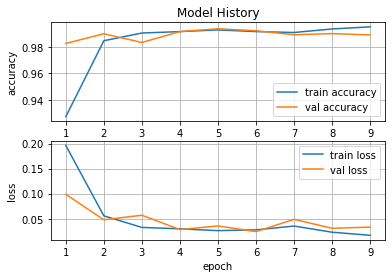

In [5]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3)

history = model.fit(
  train,
  validation_data=val,
  epochs=30,
    callbacks=[model_checkpoint, early_stopping]
)


h = pd.DataFrame(history.history)
h['epoch'] = h.index + 1


plt.subplot(2, 1, 1)
plt.plot(h['epoch'], h['accuracy'], h['epoch'], h['val_accuracy'])
plt.title('Model History')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend(('train accuracy', 'val accuracy'),
           loc='lower right')
ax1 = plt.gca()
ax1.set_xticks(range(1, max(h['epoch'])+1))


plt.subplot(2, 1, 2)
plt.plot(h['epoch'], h['loss'], h['epoch'], h['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend(('train loss', 'val loss'),
           loc='upper right')
ax2 = plt.gca()
ax2.set_xticks(range(1, max(h['epoch'])+1))

plt.show()

#model.save('temp_concrete_crack')

loaded_model = tf.keras.models.load_model(filepath)

## Make Predictions

The following cell pulls all of the test photos, converts them to arrays, gets a prediction for them, and appends the results from each photo in a dataframe. You can use the import method from above as well, but it can be a bit difficult to get the results a useful format.  

In [6]:
results = pd.DataFrame(columns=['predicted', 'actual', 'probability', 'file', 'raw_logits'])

at = 0
for label in classes: 
    path = test_path+'//'+label
    for path in glob.iglob(path + '\\*'):
        img = keras.preprocessing.image.load_img(
        path, target_size=(photo_height, photo_width)
        )
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch
        
        predictions = loaded_model.predict(img_array)
        score = tf.nn.softmax(predictions[0])
        results = results.append({'predicted': classes[np.argmax(score)], 'actual': label, 
                                  'probability': 100 * np.max(score), 'file': path,
                                 'raw_logits': score}, ignore_index=True)
        at +=1
        if at % 200 == 0:
            print(str(round(((at / 4000) * 100), 1))+'%')

        

score = accuracy_score(results['actual'], results['predicted'])
print('overall test accuracy: '+str(score))

5.0%
10.0%
15.0%
20.0%
25.0%
30.0%
35.0%
40.0%
45.0%
50.0%
55.0%
60.0%
65.0%
70.0%
75.0%
80.0%
85.0%
90.0%
95.0%
100.0%
overall test accuracy: 0.99725


## Visualize Model Error

With a test accuracy of over 99% , there were only a handful of classification errors out of 4000 test images! Not bad at all, although it seems like the mistakes it made should have been easy to catch. Let's take a look at some of them.<br>
** The formatting of the chart may look a bit funny if there are fewer photos in the specific class than there are cells in the subplot...

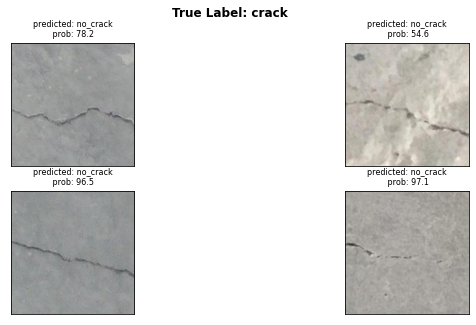

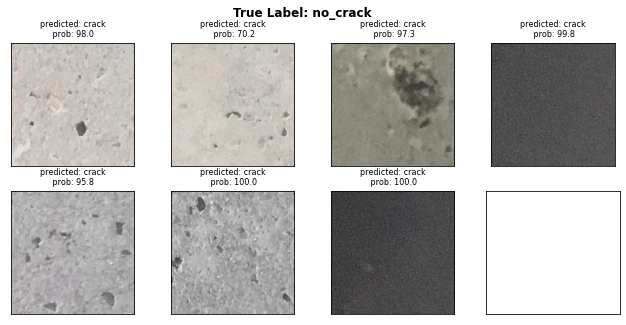

In [7]:
for i in classes:
   mistakes = results.loc[(results['predicted'] != i) & (results['actual'] == i)]
   files = mistakes['file'].tail(10).values
   fig,ax = plt.subplots(2,int(len(files) / 2) + (int(len(files) % 2 > 0)))
   fig.set_size_inches(11, 5)
   prob = mistakes['probability'].tail(10).values
   act = mistakes['actual'].tail(10).values
   pred = mistakes['predicted'].tail(10).values
   fig.suptitle('True Label: '+str(i) + '\n' + ' ', weight='bold')
   
   for i in range(0, len(files)):
       with open(files[i],'rb') as f:
           image=Image.open(f)
           ax[i%2][i//2].imshow(image)
   ax_list = fig.axes
   for ax in range(len(files)):

      ax_list[ax].set_title('predicted: '+pred[ax]+ "\n" + ' prob: '+str(round(prob[ax], 1)), fontsize=8)
   for ax in range(len(ax_list)):
      ax_list[ax].set_xticks([])
      ax_list[ax].set_yticks([])
   


## Take a look at the probability distribution for the incorrect classifications

The model was supprisingly confident on a few of the errors. One could decrease the false negative rate by filtering predictions with low probabilities (after calibration). In this context, the concequences of a false negative are high compared to those of a false positive, so a implemented system should err on the side of caution. Depending on the type of inspection a system like this would be used to improve, a single false negative could have serious consequences. Let's take a closer look:

In [8]:
pd.set_option('precision', 1)
errors = results.loc[(results['predicted'] != results['actual'])]
for row in range(len(errors)):
    print(errors.iloc[row, 0:3].values)
print('False positive mean prob: '+str(np.mean(errors['probability'].loc[(results['predicted'] != 'no_crack')])))
print('False negative mean prob: '+str(np.mean(errors['probability'].loc[(results['predicted'] == 'no_crack')])))

    

['no_crack' 'crack' 78.18598747253418]
['no_crack' 'crack' 54.6087384223938]
['no_crack' 'crack' 96.50160074234009]
['no_crack' 'crack' 97.14561104774475]
['crack' 'no_crack' 97.97905683517456]
['crack' 'no_crack' 70.16724944114685]
['crack' 'no_crack' 97.31016159057617]
['crack' 'no_crack' 99.84610080718994]
['crack' 'no_crack' 95.79927325248718]
['crack' 'no_crack' 100.0]
['crack' 'no_crack' 99.99939203262329]
False positive mean prob: 94.44303342274257
False negative mean prob: 81.6104844212532


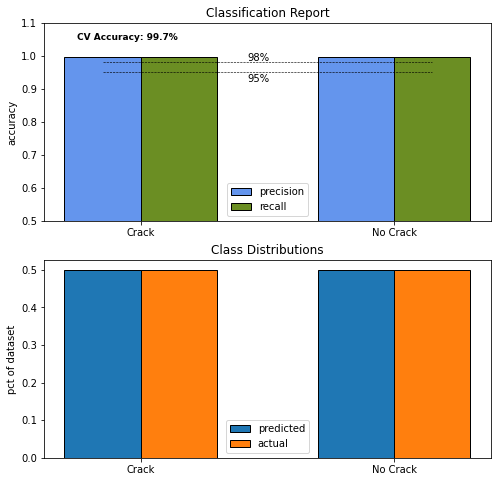

In [9]:
report = classification_report(results['actual'], results['predicted'], output_dict=True)

plt.figure(figsize=(8,8))
plt.subplot(211)
# width of the bars
barWidth = 0.3
 
bars1 = [report['crack']['precision'], report['no_crack']['precision']]
bars2 = [report['crack']['recall'], report['no_crack']['recall']]
 
# create a numerical x axis to place labels and bars on
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = np.append(r1, r2)
plt.bar(r1, bars1, width = barWidth, color = 'cornflowerblue', edgecolor = 'black', capsize=7, label='precision')
plt.bar(r2, bars2, width = barWidth, color = 'olivedrab', edgecolor = 'black', capsize=7, label='recall')

plt.text(-.1, 1.05, r'CV Accuracy: '+str(round(report['accuracy']*100, 1))+'%', fontsize=9, fontweight='bold')
ax1 = plt.gca()
ax1.set_xticks([r + (barWidth / 2) for r in range(len(bars1))])
ax1.set_xticklabels(['Crack', 'No Crack'])
plt.ylabel('accuracy')
plt.ylim([0.5, 1.1])

label = [bars1[0], bars2[0], bars1[1], bars2[1]]
plt.title('Classification Report')
plt.legend()

plt.hlines(0.95, xmin=min(r3), xmax=max(r3), color='black', linestyles='dashed', label='95%', linewidth=0.6)
plt.hlines(0.98, xmin=min(r3), xmax=max(r3), color='black', linestyles='dashed', label='98%', linewidth=0.6)
plt.text(0.57, 0.995, '98%', ha='left', va='center')
plt.text(0.57, 0.93, '95%', ha='left', va='center')


# figure 2: class distribution from predictions and train dataset as a whole


plt.subplot(212)

predicted_dist = [(results['predicted'] == 'crack').sum() / 4000, (results['predicted'] == 'no_crack').sum() / 4000]

actual_dist = [(results['actual'] == 'crack').sum() / 4000, (results['actual'] == 'no_crack').sum() / 4000]

barWidth = 0.3
 
bars1 = predicted_dist
bars2 = actual_dist
 
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, width = barWidth, color = 'tab:blue', edgecolor = 'black', capsize=7, label='predicted')
plt.bar(r2, bars2, width = barWidth, color = 'tab:orange', edgecolor = 'black', capsize=7, label='actual')
ax2 = plt.gca()
ax2.set_xticks([r + (barWidth / 2) for r in range(len(bars1))])
ax2.set_xticklabels(['Crack', 'No Crack'])
plt.ylabel('pct of dataset')
plt.legend()
plt.title('Class Distributions')


plt.show()


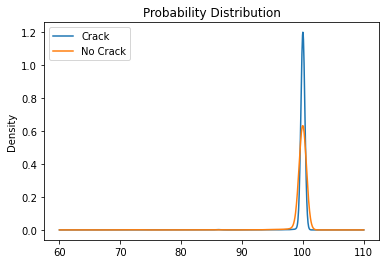

In [10]:
crack = results.loc[(results['predicted'] == 'crack')]
no_crack = results.loc[(results['predicted'] == 'no_crack')]
probs = pd.DataFrame({'Crack': crack['probability'], 'No Crack': no_crack['probability']})

ax = probs.plot.kde(ind=[i for i in np.linspace(start = 60, stop = 110, num = 1000)], 
                    title='Probability Distribution', xlabel='Probability')

The kernal density estimation plot suggests there are probabilities over 100%, which there are not; this is an artifact of the kde smoothing algorythm. It seems as though there should be more uncertainty in some of the classifications. We can take a closer look at this by making probability reliability diagram for the model:

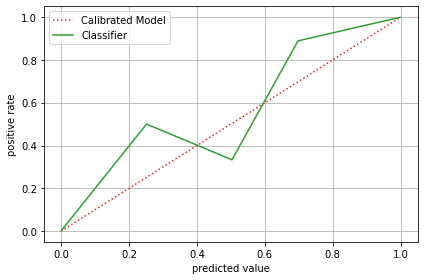

In [16]:
prob_no_crack = []
for i in range(len(results)):
    logits = results['raw_logits'][i]
    prob_no_crack.append(logits[1])

prob_true_binary, prob_pred_binary = calibration_curve(
        results['actual'].map({'crack': 0, 'no_crack': 1}), 
        prob_no_crack, n_bins=5, normalize=False)


fig = plt.figure()
ax = plt.gca()

plt.plot([0, 1], [0, 1], color='tab:red', linestyle=":", label="Calibrated Model")
plt.plot(prob_pred_binary, prob_true_binary, label='Classifier', color="tab:green")

plt.ylabel('positive rate')
plt.xlabel('predicted value')

plt.legend()
plt.yticks()
plt.grid(True)
plt.tight_layout()

plt.show()

Ideally, there would be the same distribution of probabilities as values (on a zero to one scale) to be able to fully trust the model's stated probability for a given prediction. The model built above is not perfectly calibrated, and would benefit from some type of calibration for a final model system to be useful. Research into the true meaning of these probabilities in deep neural networks is still quite young. There are some failry simple calibration techniques (like isotonic regression), and for the sake of time I will skip this step and show the effect of setting probability thresholds for the model. 

## Choosing a Probability Threshold


By default, I used classes[np.argmax(score)] to make a prediction for each photo in the test set. This will choose the class based simply on the class with the highest probability from the output of the model. While this is often a decent way to go, in this case, the consequences of a false negative are high (the model missing a crack). Thus, we can artificially create a third class, 'not sure', that would contain all model predictions below a certain probability threshold. While this may solve the false negative problem, the tradeoff is potentially foregoing predictions that the model was pretty sure about but not certain (called false refrains below). In this example a person would have to go out and determine 'crack' or 'no_crack' manually. The below code shows this tradeoff on the test dataset:

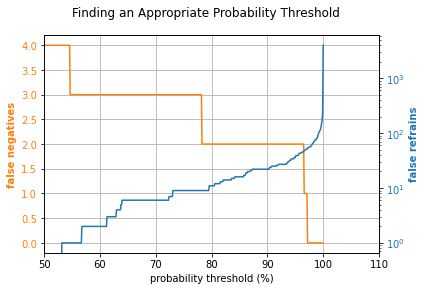

In [12]:
thresholds = [i for i in np.linspace(0.0, 100.0, num=1000)]
prob_tuning = pd.DataFrame(columns=[
    'threshold', 'false_negatives', 'false_refrains', 'under_threshold'])

for threshold in thresholds:
    false_neg = 0
    false_refrain = 0
    under_threshold = 0
    for z in range(len(results)):
        true = results['actual'][z]
        pred = results['predicted'][z]
        prob = results['probability'][z]
        if prob <= threshold:
            under_threshold += 1
        if prob <= threshold and pred == true:
            false_refrain += 1
        if prob > threshold and pred == 'no_crack' and true == 'crack':
            false_neg += 1
    prob_tuning = prob_tuning.append(
       {'threshold': threshold, 'false_negatives': false_neg, 'false_refrains': false_refrain, 
        'under_threshold': under_threshold}, ignore_index=True) 


            
            
fig, ax1 = plt.subplots()

color = 'tab:orange'
ax1.set_xlabel('probability threshold (%)')
ax1.set_ylabel('false negatives', color=color, fontweight='bold')
ax1.plot(prob_tuning['threshold'], prob_tuning['false_negatives'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlim(50, 110)
ax1.grid(True)
ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('false refrains', color=color, fontweight='bold')  
ax2.plot(prob_tuning['threshold'], prob_tuning['false_refrains'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale('log')

#fig.tight_layout()
fig.suptitle('Finding an Appropriate Probability Threshold')
plt.show()    

tf.keras.backend.clear_session()

In [13]:
# delete all files downloaded in this notebook
from git import rmtree


rmtree('./'+filepath)



# Conclusion

The model designed here is quite simple and very effective. It is important to keep in mind this is a unusually simple computer vision problem, and the data is unusually clean. Even so, it is impressive that such a simple neural network can do so well. Although having any false negatives may be unacceptable in some circumstances, in many contexts a skilled professional would have a higher mistake rate than the model has. Additionally, further tuning and calibration of the model may produce probabilities that are more predictable for difficult images. Another tactic you could use to impove performance would be to augment some of the images the model had trouble with (rotate, change hue, stretch, mirror) to impove representation of difficult photos in the training dataset. 